In [ ]:
# Obtain daatset
!pip install datasets

# Word cloud
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
# Imports
from datasets import load_dataset, Dataset

import matplotlib.pyplot as plt

import numpy as np

from sklearn.utils import class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB

from collections import Counter, defaultdict

from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')


import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Dataset loading
data = load_dataset("emotion", trust_remote_code = True)

# Obtaining training, testing and validation data
X_train = data['train']['text']
y_train = data['train']['label']

X_test = data['test']['text']
y_test = data['test']['label']

X_val = data['validation']['text']
y_val = data['validation']['label']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Confirming dimensions
print(f"The length of the training set is {len(X_train)} for the texts and {len(y_train)} for labels")
print(f"The length of the test set is {len(X_test)} for the texts and {len(y_test)} for the labels")
print(f"The length of the validation set is {len(X_val)} for the texts and {len(y_val)} for the labels")

The length of the training set is 16000 for the texts and 16000 for labels
The length of the test set is 2000 for the texts and 2000 for the labels
The length of the validation set is 2000 for the texts and 2000 for the labels


In [ ]:
# Confirming appropriate data type in labels
print(type(y_train[0]))

<class 'int'>


In [ ]:
# Printing the first 5 sentences
for i in range(5):
  print(y_train[i], X_train[i])

0 i didnt feel humiliated
0 i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
3 im grabbing a minute to post i feel greedy wrong
2 i am ever feeling nostalgic about the fireplace i will know that it is still on the property
3 i am feeling grouchy


In [ ]:
# Checking unique labels
unique_labels = set(y_train)
print(unique_labels)

{0, 1, 2, 3, 4, 5}


In [ ]:
# Checking class imbalance
print(Counter(y_train))

Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})


(array([1833., 3659., 3524., 2709., 1813., 1043.,  701.,  376.,  219.,
         123.]),
 array([  7. ,  36.3,  65.6,  94.9, 124.2, 153.5, 182.8, 212.1, 241.4,
        270.7, 300. ]),
 <BarContainer object of 10 artists>)

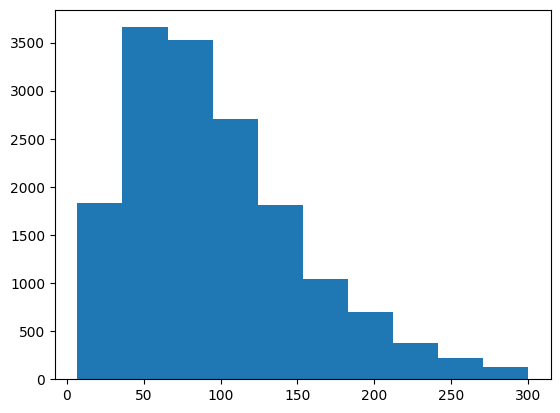

In [ ]:
# Checking distribution of text lengths
text_lengths = []
for sentence in X_train:
  length = len(sentence)
  text_lengths.append(length)

plt.hist(text_lengths)

In [ ]:
# Maximum sentence length
print(max(text_lengths))

300


In [ ]:
# Obtaining indices of the different classes
sad_idx = [i for i in range(len(y_train)) if y_train[i] == 0]
joy_idx = [i for i in range(len(y_train)) if y_train[i] == 1]
love_idx = [i for i in range(len(y_train)) if y_train[i] == 2]
anger_idx = [i for i in range(len(y_train)) if y_train[i] == 3]
fear_idx = [i for i in range(len(y_train)) if y_train[i] == 4]
surprise_idx = [i for i in range(len(y_train)) if y_train[i] == 5]

In [ ]:
# Removing these words since they are common in all classes for visualisation
words_to_remove = ['feel', 'feeling']

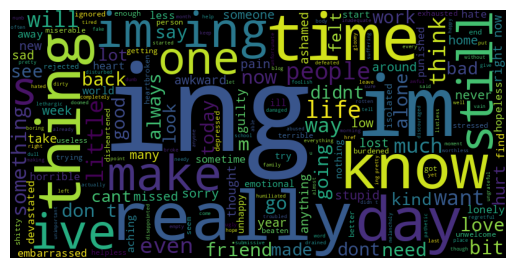

In [ ]:
# Visualising word cloud for "sadness"
sad_txt = " ".join([X_train[sad_idx[i]] for i in range(len(sad_idx))])

for word in words_to_remove:
  sad_txt = sad_txt.replace(word, '')

sad_cloud = WordCloud(width=800, height=400).generate(sad_txt)
plt.imshow(sad_cloud)
plt.axis('off')
plt.show()

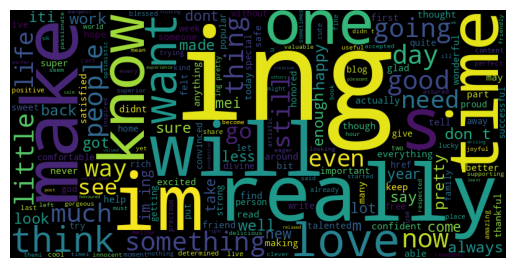

In [ ]:
# Visualising word cloud for "joy"
joy_txt = ''.join([X_train[joy_idx[i]] for i in range(len(joy_idx))])

for word in words_to_remove:
  joy_txt = joy_txt.replace(word, '')

joy_cloud = WordCloud(width = 800, height = 400).generate(joy_txt)
plt.imshow(joy_cloud)
plt.axis('off')
plt.show()

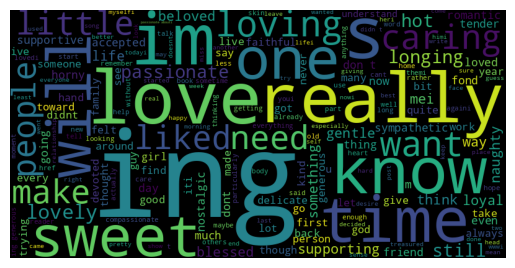

In [ ]:
# Visualising word cloud for "love"
love_txt = ''.join([X_train[love_idx[i]] for i in range(len(love_idx))])

for word in words_to_remove:
  love_txt = love_txt.replace(word, '')

love_cloud = WordCloud(width = 800, height = 400).generate(love_txt)
plt.imshow(love_cloud)
plt.axis('off')
plt.show()

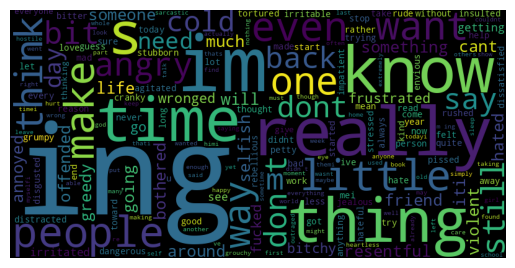

In [ ]:
# Visualising word cloud for "anger"
anger_txt = ''.join([X_train[anger_idx[i]] for i in range(len(anger_idx))])

for word in words_to_remove:
  anger_txt = anger_txt.replace(word, '')

anger_cloud = WordCloud(width = 800, height = 400).generate(anger_txt)
plt.imshow(anger_cloud)
plt.axis('off')
plt.show()

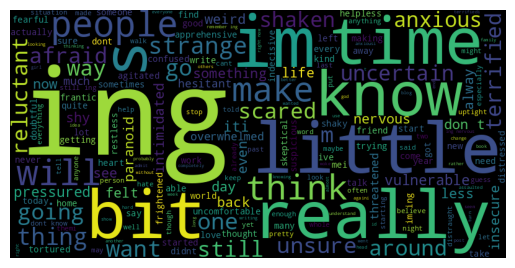

In [ ]:
# Visualising word cloud for "fear"
fear_txt = ''.join([X_train[fear_idx[i]] for i in range(len(fear_idx))])

for word in words_to_remove:
  fear_txt = fear_txt.replace(word, '')

fear_cloud = WordCloud(width = 800, height = 400).generate(fear_txt)
plt.imshow(fear_cloud)
plt.axis('off')
plt.show()

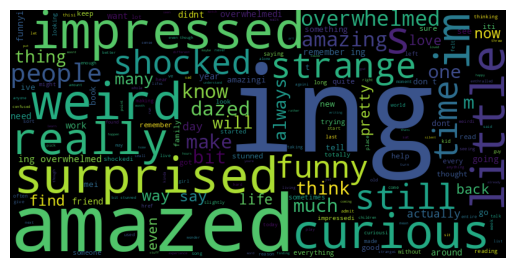

In [ ]:
# Visualising word cloud for "surprise"
surprise_txt = ''.join([X_train[surprise_idx[i]] for i in range(len(surprise_idx))])

for word in words_to_remove:
  surprise_txt = surprise_txt.replace(word, '')

surprise_cloud = WordCloud(width = 800, height = 400).generate(surprise_txt)
plt.imshow(surprise_cloud)
plt.axis('off')
plt.show()

In [ ]:
# Rule-based classifier

def classify_emotions(X):
  """
  Rule-based classifier based on top 5 class words present in a sentence

  Parameters:
  - X (list): A list of list of strings containing a set of sentences to classify

  Returns:
  - y_pred (list): A list of lists containing the labels for X

  """

  # Define words
  sad_words = ["hurt", 'unhappy', 'lost', 'sorry', 'low']
  joy_words = ['life', 'happy', 'love', 'excited', 'want']
  love_words = ['love', 'loving', 'passionate', 'sweet', 'caring']
  anger_words = ['offended','angry','heated','resentful', 'cold']
  fear_words = ['strange','reluctant','people','shaken','terrified']
  surprised_words = ['amazing', 'weird','amazed','surprised','impressed']
  emotion = 1 # Default emotion
  y_pred = [1] * len(X) # Define size of precdictions
  i = 0

  # Classification
  for sentence in X:
    words = sentence.split()
    for word in words:
      if word in sad_words:
        emotion = 0
        y_pred[i] = emotion
        i += 1
        break
      if word in joy_words:
        emotion = 1
        y_pred[i] = emotion
        i += 1
        break
      if word in love_words:
        emotion = 2
        y_pred[i] = emotion
        i += 1
        break
      if word in anger_words:
        emotion = 3
        y_pred[i] = emotion
        i += 1
        break
      if word in fear_words:
        emotion = 4
        y_pred[i] = emotion
        i += 1
        break
      if word in surprised_words:
        emotion = 5
        y_pred[i] = emotion
        i += 1
        break
  return y_pred

y_pred_rule_based = classify_emotions(X_test)

In [ ]:
# Obtain classification report
print(f"Classification report for rule-based classifier: \n{classification_report(y_test, y_pred_rule_based)}")

Classification report for rule-based classifier: 
              precision    recall  f1-score   support

           0       0.36      0.03      0.05       581
           1       0.36      0.88      0.51       695
           2       0.08      0.02      0.03       159
           3       0.10      0.01      0.03       275
           4       0.12      0.05      0.07       224
           5       0.03      0.03      0.03        66

    accuracy                           0.33      2000
   macro avg       0.17      0.17      0.12      2000
weighted avg       0.26      0.33      0.21      2000



In [ ]:
# Obtaining word embeddings via CountVectorizer()
vectoriser = CountVectorizer()
X_train_cv = vectoriser.fit_transform(X_train)
X_test_cv = vectoriser.transform(X_test)

In [ ]:
# Training a random dummy classifier
random_dummy_clf = DummyClassifier(strategy='stratified')
random_dummy_clf.fit(X_train_cv, y_train)
y_pred_random_dummy_cv = random_dummy_clf.predict(X_test_cv)

In [ ]:
# Classification report
print(f"Classification report for classifier: {random_dummy_clf} \n {classification_report(y_test, y_pred_random_dummy_cv)}")

Classification report for classifier: DummyClassifier(strategy='stratified') 
               precision    recall  f1-score   support

           0       0.30      0.31      0.31       581
           1       0.33      0.34      0.34       695
           2       0.08      0.07      0.07       159
           3       0.15      0.13      0.14       275
           4       0.12      0.12      0.12       224
           5       0.05      0.06      0.05        66

    accuracy                           0.25      2000
   macro avg       0.17      0.17      0.17      2000
weighted avg       0.25      0.25      0.25      2000



In [ ]:
# Training a majority dummy classifier
majority_dummy_clf = DummyClassifier(strategy='most_frequent')
majority_dummy_clf.fit(X_train_cv, y_train)
y_pred_majority_dummy_cv = majority_dummy_clf.predict(X_test_cv)

In [ ]:
# Classification report
print(f"Classification report for classifier {majority_dummy_clf} \n {classification_report(y_test, y_pred_majority_dummy_cv)}")

Classification report for classifier DummyClassifier(strategy='most_frequent') 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       581
           1       0.35      1.00      0.52       695
           2       0.00      0.00      0.00       159
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       224
           5       0.00      0.00      0.00        66

    accuracy                           0.35      2000
   macro avg       0.06      0.17      0.09      2000
weighted avg       0.12      0.35      0.18      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Training a Naive Bayes classifier
naive_bayes_clf = MultinomialNB()
naive_bayes_clf.fit(X_train_cv, y_train)
y_pred_naive_bayes = naive_bayes_clf.predict(X_test_cv)

In [ ]:
# Classification report
print(f"Classification report for classifier {naive_bayes_clf} \n {classification_report(y_test, y_pred_naive_bayes)}")

Classification report for classifier MultinomialNB() 
               precision    recall  f1-score   support

           0       0.74      0.94      0.83       581
           1       0.74      0.97      0.84       695
           2       0.95      0.23      0.37       159
           3       0.92      0.57      0.70       275
           4       0.82      0.53      0.64       224
           5       0.00      0.00      0.00        66

    accuracy                           0.77      2000
   macro avg       0.69      0.54      0.56      2000
weighted avg       0.77      0.77      0.73      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
# Training an SVM classifier
svc_clf_cv = SVC(kernel='linear', verbose=True, C= 0.6, gamma='auto', class_weight = 'balanced')
svc_clf_cv.fit(X_train_cv, y_train)
y_pred_svc = svc_clf_cv.predict(X_test_cv)

[LibSVM]

In [ ]:
# Classification report
print(f"Classification report for classifier {svc_clf_cv} \n {classification_report(y_test, y_pred_svc)}")

Classification report for classifier SVC(C=0.6, class_weight='balanced', gamma='auto', kernel='linear', verbose=True) 
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       581
           1       0.93      0.88      0.91       695
           2       0.69      0.86      0.77       159
           3       0.88      0.89      0.88       275
           4       0.86      0.86      0.86       224
           5       0.63      0.77      0.69        66

    accuracy                           0.88      2000
   macro avg       0.82      0.86      0.84      2000
weighted avg       0.89      0.88      0.88      2000



In [ ]:
# Obtaining Tf-IDF features
tfidf_vectoriser = TfidfVectorizer()
X_train_tfidf = tfidf_vectoriser.fit_transform(X_train)
X_test_tfidf = tfidf_vectoriser.transform(X_test)

In [ ]:
# Random dummy classifier
random_dummy_clf = DummyClassifier(strategy='stratified')
random_dummy_clf.fit(X_train_tfidf, y_train)
y_pred_random_tfidf = random_dummy_clf.predict(X_test_tfidf)

In [ ]:
# Classification report
print(f"Classification report for classifier {random_dummy_clf}: \n {classification_report(y_test,y_pred_random_tfidf)}")

Classification report for classifier DummyClassifier(strategy='stratified'): 
               precision    recall  f1-score   support

           0       0.31      0.31      0.31       581
           1       0.37      0.36      0.37       695
           2       0.11      0.11      0.11       159
           3       0.17      0.16      0.17       275
           4       0.10      0.10      0.10       224
           5       0.01      0.02      0.01        66

    accuracy                           0.26      2000
   macro avg       0.18      0.18      0.18      2000
weighted avg       0.26      0.26      0.26      2000



In [ ]:
# Training a most-frequent based dummy classifier
majority_dummy_clf = DummyClassifier(strategy='most_frequent')
majority_dummy_clf.fit(X_train_tfidf, y_train)
y_pred_majority_dummy_tfidf = majority_dummy_clf.predict(X_test_tfidf)

In [1]:
# Classification report
print(f"Classification report for classfier {majority_dummy_clf}: \n {classification_report(y_test, y_pred_majority_dummy_tfidf)}")

NameError: name 'majority_dummy_clf' is not defined

In [ ]:
# Training a Multinomial Naive Bayes classifier
naive_bayes_clf = MultinomialNB()
naive_bayes_clf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = naive_bayes_clf.predict(X_test_tfidf)

In [ ]:
# Classification report
print(f"Classification report for classifier {naive_bayes_clf}: \n {classification_report(y_test, y_pred_nb_tfidf)}")

Classification report for classifier MultinomialNB(): 
               precision    recall  f1-score   support

           0       0.67      0.90      0.77       581
           1       0.60      0.99      0.75       695
           2       1.00      0.03      0.05       159
           3       0.96      0.16      0.28       275
           4       1.00      0.18      0.31       224
           5       0.00      0.00      0.00        66

    accuracy                           0.65      2000
   macro avg       0.71      0.38      0.36      2000
weighted avg       0.73      0.65      0.56      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Training an SVC
svc_clf = SVC(kernel='rbf', verbose = True, C=0.6, gamma='auto', class_weight = 'balanced')
svc_clf.fit(X_train_tfidf, y_train)
y_pred_svc_tfidf = svc_clf.predict(X_test_tfidf)

[LibSVM]

In [ ]:
# Classification report
print(f"Classification report for classifier {svc_clf}: \n {classification_report(y_test, y_pred_svc_tfidf)}")

Classification report for classifier SVC(C=0.6, class_weight='balanced', gamma='auto', verbose=True): 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       581
           1       0.00      0.00      0.00       695
           2       0.00      0.00      0.00       159
           3       0.00      0.00      0.00       275
           4       0.11      1.00      0.20       224
           5       0.00      0.00      0.00        66

    accuracy                           0.11      2000
   macro avg       0.02      0.17      0.03      2000
weighted avg       0.01      0.11      0.02      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Reconfigure bert base to have 6 output classes
config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = 6

# Pretrained tokeniser and model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, tokeniser):
      """
      Initialise the CustomDataset object.

      Parameters:
      - data (list): A list of dictionaries containing the text and labels
      - tokeniser : The tokeniser object used for tokenisation

      """
      self.tokeniser = tokeniser
      self.input_ids = [] # List to store input ids
      self.attention_mask = [] # List to store attention masks
      self.labels = [item['label'] for item in data] # Extract labels from data
      self.tokenise_data([item['text'] for item in data]) # Extract tokenised text from data

    def tokenise_data(self, texts):
      """
      Tokenise the input.

      Parameters:
      - texts (list): A list of input texts
      """
      for txt in texts:
        # Tokenise each sentence
        encoded_txt = self.tokeniser(txt, truncation = True, padding='max_length', max_length = 140, return_tensors = 'pt')
        self.input_ids.append(encoded_txt['input_ids']) # Store input ids
        self.attention_mask.append(encoded_txt['attention_mask']) # Stope attention masks
    def __len__(self):
      """
      Obtain the length of dataset

      Returns:
      - int: the number of samples in the dataset
      """
      return len(self.labels)

    def __getitem__(self, idx):
      """
      Get a sample from the dataset at the specified index

      Parameters:
      - idx (list): The list of indices to retrieve samles from

      Returns:
      - dict: A dictionary containing input ids, attention masks and labels

      """
      batch_input_ids = [self.input_ids[i] for i in idx] # Retrieve input ids
      batch_attention_mask = [self.attention_mask[i] for i in idx] # Retrieve attention masks
      batch_labels = [self.labels[i] for i in idx] # Retrieve labels
      return {'input_ids' : batch_input_ids, 'attention_mask': batch_attention_mask, 'label':batch_labels}

NameError: name 'Dataset' is not defined

In [ ]:
# Turn data into dictionary like instancce
train_data = [{'text': sentence, 'label':emotion} for sentence, emotion in zip(X_train, y_train)]
test_data = [{'text': sentence, 'label':emotion} for sentence, emotion in zip(X_test, y_test)]
val_data = [{'text': sentence, 'label':emotion} for sentence, emotion in zip(X_val, y_val)]

In [ ]:
# Obtain dataset
train_dataset = CustomDataset(train_data, tokeniser)
test_dataset = CustomDataset(test_data, tokeniser)
val_dataset = CustomDataset(val_data, tokeniser)

In [ ]:
# Obtain dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle=False)

In [ ]:
class EmotionClassifier(nn.Module):
  def __init__(self, model):
    """
    Create instance of class

    Parameters:
    - model : the bert base model
    """
    super(EmotionClassifier, self).__init__()
    self.model = model # Store BERT model
    self.linear = nn.Linear(model.config.hidden_size, 6) # Linear output layer

  def forward(self, input_ids, attention_mask):
    """
    Perform a forward pass through the network

    Parameters:
    - input_ids: Tensor of input token ids
    - attention_mask: Tensor indicating which tokens should be attended to

    Returns:
    - losits (Tensor): ligits for emotion classification
    """
    input_ids = input_ids.squeeze(1)
    attention_mask = attention_mask.squeeze(1)
    outputs = self.model(input_ids = input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    logits = logits.squeeze(-1)
    return logits

In [ ]:
clf = EmotionClassifier(model) # Initialise classifier

In [ ]:
# Define training
def train(clf, train_loader, val_loader, optimiser, loss_fn, device):
  """
  Train the classfifier model

  Parameters:
  - clf (nn.Module): the classifier model to train
  - train_loader (DataLoader): DataLoader for training data
  - val_loader (DataLoader): DataLoader for vliadation data
  - optimiser: optimiser for updating model parameters
  - loss_fn: loss function to compute the loss
  - devide (torch.device): Device to run the computations on

  """
     clf.train() # Set model to training mode
     total_loss = 0
     for batch in train_loader:
       input_ids = batch['input_ids'].to(device)
       attention_mask = batch['attention_mask'].to(device)
       labels = batch['label'].to(device)

       optimiser.zero_grad() # Zero the gradients
       outputs = clf(input_ids, attention_mask) # Forward pass

       _, predicted = torch.max(outputs, 1) # Get predicted label
       loss = loss_fn(outputs, labels.long()) # Computw the loss
       total_loss += loss # Accumulate loss
       loss.backward() # Backpro
       optimiser.step() # Update parameters
     print(f"Total loss: {total_loss}")
     _, eval_accuracy = evaluate(clf, val_loader, device) # Evaluate on validation data
     print(f"Validation accuracy {eval_accuracy}")


def evaluate(clf, data_loader, device):
  """
  Evaluate the classifier model

  Parameters:
  - clf (nn.Module): The classfier to evaluate
  - data_loader (DataLoader): DataLoader for the evaluation data
  - device (torch.device): Device to run the computations on

  Returns:
  - y_pred (list): list of tensors with predicted labels
  - accuracy (float): the accuracy of model over the evaluation set
  """
  clf.eval() # Set model to evaluation mode
  correct = 0
  total = 0
  y_pred = []
  with torch.no_grad():
   for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = clf(input_ids= input_ids, attention_mask = attention_mask) # Get predicted labels
      _, predictions = torch.max(outputs, 1)
      y_pred.extend(predictions)
      total += labels.size(0)
      correct +=(predictions == labels).sum().item()
  return y_pred, correct/total

In [ ]:
# Set computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clf.to(device)

# Define optimiser and loss function
optimiser = AdamW(clf.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()
epochs = 1

# Train
for epoch in range(epochs):
  train(clf, train_loader, val_loader, optimiser, loss_fn, device)
  y_pred_bert, accuracy = evaluate(clf, test_loader, device)
  print(f"Epoch {epoch}, accuracy {accuracy*100}%")



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total loss: 137.09707641601562
Validation accuracy 0.939
Epoch 0, accuracy 92.65%


In [ ]:
y_pred = [tensor.tolist() for tensor in y_pred_bert] # Convert tensorts within list to list

In [ ]:
# Classification report
print(f"Classification report for {clf} \n {classification_report(y_test, y_pred)}")

Classification report for EmotionClassifier(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_fe

In [64]:
# Drive set up
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
# Save primary model
path = "/content/drive/MyDrive/NLP/Project/Code/BERT.pth"
torch.save(clf, path)

In [71]:
# Save SVM
from joblib import dump
path = "/content/drive/MyDrive/NLP/Project/Code/SVC.joblib"
dump(svc_clf_cv,path)

['/content/drive/MyDrive/NLP/Project/Code/SVC.joblib']

<Figure size 640x480 with 0 Axes>

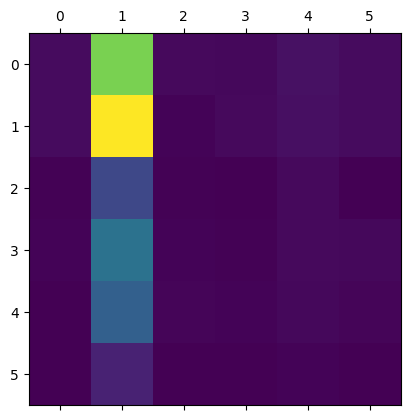

<Figure size 640x480 with 0 Axes>

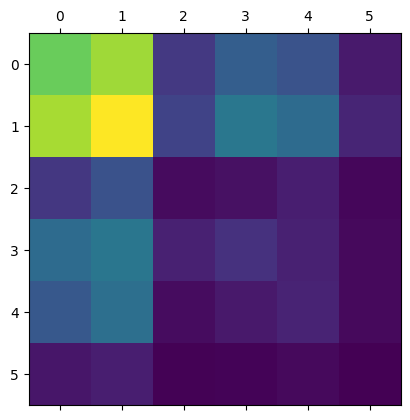

<Figure size 640x480 with 0 Axes>

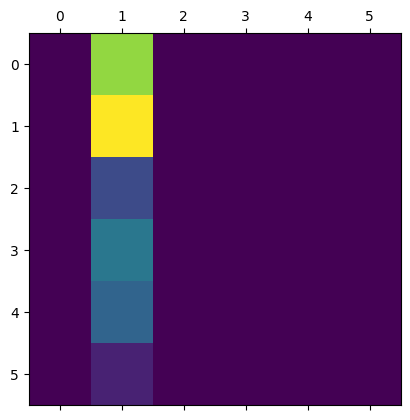

<Figure size 640x480 with 0 Axes>

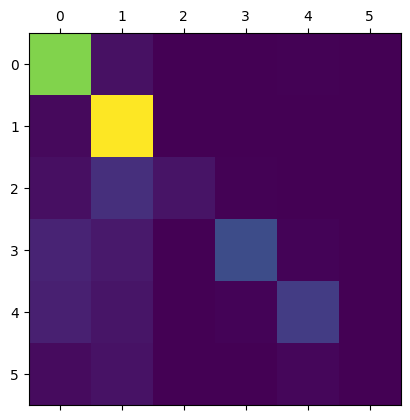

<Figure size 640x480 with 0 Axes>

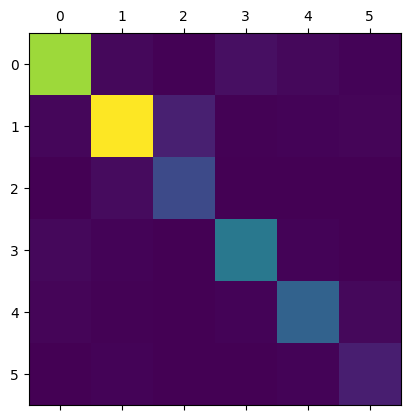

<Figure size 640x480 with 0 Axes>

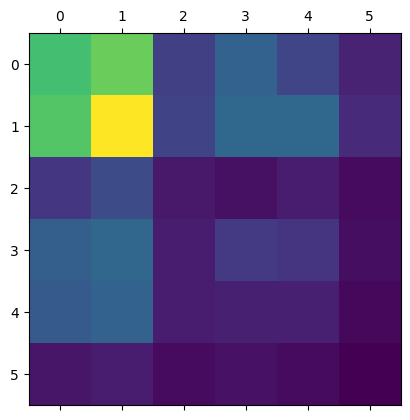

<Figure size 640x480 with 0 Axes>

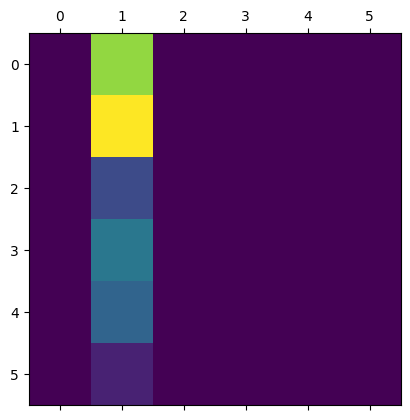

<Figure size 640x480 with 0 Axes>

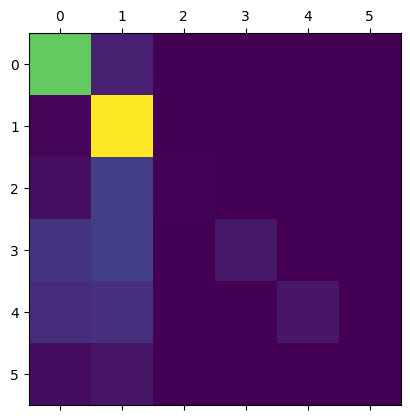

<Figure size 640x480 with 0 Axes>

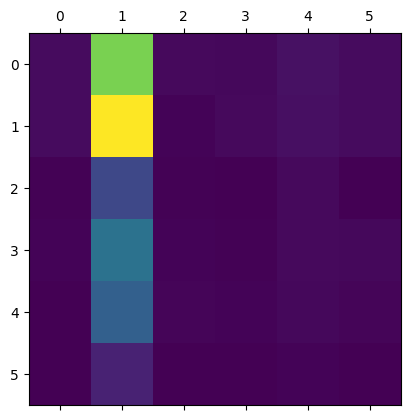

<Figure size 640x480 with 0 Axes>

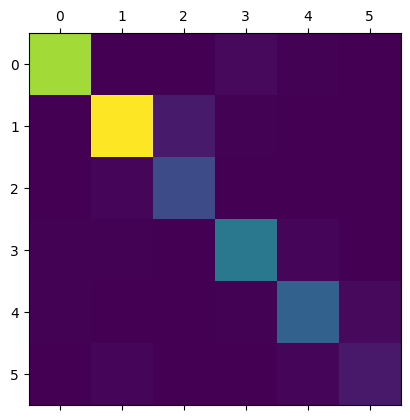

In [74]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

# Rule based
plt.figure()
rule_based_matrix = confusion_matrix(y_test, y_pred_rule_based)
plt.matshow(rule_based_matrix)

# Random with CV
plt.figure()
random_cv_matrix = confusion_matrix(y_test, y_pred_random_dummy_cv)
plt.matshow(random_cv_matrix)

# Majority with CV
plt.figure()
majority_cv_matrix = confusion_matrix(y_test, y_pred_majority_dummy_cv)
plt.matshow(majority_cv_matrix)

# Naive Bayes with CV
plt.figure()
nb_cv_matrix = confusion_matrix(y_test, y_pred_naive_bayes)
plt.matshow(nb_cv_matrix)

# SVM with CV
plt.figure()
svc_cv_matrix = confusion_matrix(y_test, y_pred_svc)
plt.matshow(svc_cv_matrix)

# Random with TF-IDF
plt.figure()
random_tfidf_matrix = confusion_matrix(y_test, y_pred_random_tfidf)
plt.matshow(random_tfidf_matrix)

# Majority with TFIDF
plt.figure()
majority_tfidf_matrix = confusion_matrix(y_test, y_pred_majority_dummy_tfidf)
plt.matshow(majority_tfidf_matrix)

# Naive Bayes with TD-IDF
plt.figure()
nb_tfidf_matrix = confusion_matrix(y_test, y_pred_nb_tfidf)
plt.matshow(nb_tfidf_matrix)

# SVM with TF-IDF
plt.figure()
svc_tfidf_matrix = confusion_matrix(y_test, y_pred_svc_tfidf)
plt.matshow(rule_based_matrix)

# BERT
plt.figure()
bert_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(bert_matrix)

In [101]:
# Obtain indices
y_wrong_rule_idx = [i for i in range(len(y_test)) if y_pred_rule_based[i] != y_test[i]]
for i in range(2):
  idx = y_wrong_rule_idx[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_rule_based[idx]} but true label {y_test[idx]}")

Sentence: im feeling rather rotten so im not very ambitious right now misclassified as 1 but true label 0
Sentence: im updating my blog because i feel shitty misclassified as 4 but true label 0


In [102]:
# Obtain indices
y_wrong_random_cv_idx = [i for i in range(len(y_test)) if y_pred_random_dummy_cv[i] != y_test[i]]

# Error analysis
for i in range(2):
  idx = y_wrong_random_cv_idx[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_random_dummy_cv[idx]} but true label {y_test[idx]}")

Sentence: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived misclassified as 0 but true label 1
Sentence: i was feeling a little vain when i did this one misclassified as 1 but true label 0


In [103]:
# Obtain indices
y_wrong_majority_cv_idx = [i for i in range(len(y_test)) if y_pred_majority_dummy_cv[i] != y_test[i]]

# Error analysis
for i in range(2):
  idx = y_wrong_majority_cv_idx[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_majority_dummy_cv[idx]} but true label {y_test[idx]}")

Sentence: im feeling rather rotten so im not very ambitious right now misclassified as 1 but true label 0
Sentence: im updating my blog because i feel shitty misclassified as 1 but true label 0


In [104]:
# Obtain indices
y_nb_cv_idx = [i for i in range(len(y_test)) if y_pred_naive_bayes[i] != y_test[i]]

# Error analysis
for i in range(2):
  idx = y_nb_cv_idx[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_naive_bayes[idx]} but true label {y_test[idx]}")

Sentence: i cant walk into a shop anywhere where i do not feel uncomfortable misclassified as 1 but true label 4
Sentence: i felt anger when at the end of a telephone call misclassified as 0 but true label 3


In [105]:
# Obtain indices
y_wrong_svc_cv = [i for i in range(len(y_test)) if y_pred_svc[i] != y_test[i]]

# Error analysis
for i in range(2):
  idx = y_wrong_svc_cv[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_svc[idx]} but true label {y_test[idx]}")

Sentence: i don t feel particularly agitated misclassified as 3 but true label 4
Sentence: im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years misclassified as 1 but true label 0


In [107]:
# Obtain indices
y_wrong_random_tfidf_idx = [i for i in range(len(y_test)) if y_pred_random_tfidf[i] != y_test[i]]

# Error analysis
for i in range(5):
  idx = y_wrong_random_tfidf_idx[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_random_tfidf[idx]} but true label {y_test[idx]}")

Sentence: im feeling rather rotten so im not very ambitious right now misclassified as 3 but true label 0
Sentence: im updating my blog because i feel shitty misclassified as 4 but true label 0
Sentence: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived misclassified as 3 but true label 1
Sentence: i was feeling a little vain when i did this one misclassified as 5 but true label 0
Sentence: i cant walk into a shop anywhere where i do not feel uncomfortable misclassified as 1 but true label 4


In [109]:
# Obtain indices
y_wrong_majority_tfidf = [i for i in range(len(y_test)) if y_pred_majority_dummy_tfidf[i] != y_test[i]]

# Error analysis
for i in range(3):
  idx = y_wrong_majority_tfidf[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_majority_dummy_tfidf[idx]} but true label {y_test[idx]}")

Sentence: im feeling rather rotten so im not very ambitious right now misclassified as 1 but true label 0
Sentence: im updating my blog because i feel shitty misclassified as 1 but true label 0
Sentence: i never make her separate from me because i don t ever want her to feel like i m ashamed with her misclassified as 1 but true label 0


In [112]:
# Obtain indices
y_wrong_nb_tfidf = [i for i in range(len(y_test)) if y_pred_nb_tfidf[i] != y_test[i]]

# Errpr analusis
for i in range(2):
  idx = y_wrong_nb_tfidf[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_nb_tfidf[idx]} but true label {y_test[idx]}")

Sentence: i cant walk into a shop anywhere where i do not feel uncomfortable misclassified as 1 but true label 4
Sentence: i felt anger when at the end of a telephone call misclassified as 1 but true label 3


In [113]:
# Obtain indices
y_wrong_svc_tfidf = [i for i in range(len(y_test)) if y_pred_svc_tfidf[i] != y_test[i]]

# Error analysis
for i in range(3):
  idx = y_wrong_svc_tfidf[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred_svc_tfidf[idx]} but true label {y_test[idx]}")

Sentence: im feeling rather rotten so im not very ambitious right now misclassified as 4 but true label 0
Sentence: im updating my blog because i feel shitty misclassified as 4 but true label 0
Sentence: i never make her separate from me because i don t ever want her to feel like i m ashamed with her misclassified as 4 but true label 0


In [114]:
# Obtain indices
y_wrong_idx = [i for i in range(len(y_test)) if y_pred[i] != y_test[i]]

# Error analysis
for i in range(2):
  idx = y_wrong_idx[i]
  print(f"Sentence: {X_test[idx]} misclassified as {y_pred[idx]} but true label {y_test[idx]}")

Sentence: i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia misclassified as 2 but true label 1
Sentence: i feel if i completely hated things i d exercise my democratic right speak my mind in what ever ways possible and try to enact a change misclassified as 0 but true label 3
